# Bank Marketing Dataset: Neural Network Model
---
Course SWE303 Project
---
Klaudia Tamburi,

Epoka University, Software Engineering

---

Dataset link: https://archive.ics.uci.edu/dataset/222/bank+marketing

State of art: 90.48% - https://api.semanticscholar.org/CorpusID:15627504

## Initial Set Up

### Import Librarias

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.utils import resample, shuffle
import warnings
warnings.filterwarnings("ignore")

# Setting  up seeds for the model and data splitting randomnes for reproducibility and consistency
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
random_state=42

### Helper Functions

In [17]:
# Functions to make it easier
# Custom f1 score method
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Train history of model
def history_graph(training_results,train_history,validation_history,train_label,validation_label,title,y_axis,x_axis='Epochs'):
  plt.plot(training_results.history[train_history], label=train_label)
  plt.plot(training_results.history[validation_history], label=validation_label)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(y_axis)
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  print()

# Number of false and true predictions plot
def heatmap(label_1, label_2, cm):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  xticklabels=[label_1, label_2], yticklabels=[label_1, label_2])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()
  print()

# Plot Coorelation Heatmap
def plot_heatmap(X, feature_names=None, title="Correlation Heatmap"):

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=feature_names)

    corr_matrix = X.corr()

    plt.figure(figsize=(30, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title)
    plt.show()

### Set Up Dataset

In [18]:
# Read data from file
data = pd.read_csv('bank-additional-full.csv', sep=';')
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Preprocess Data

### Drop Data

In [19]:
# There are no empty values in this dataset, but just making sure - Dropping data with empty values
data = data.dropna()

# Dropping unknown values since its the same as having empty values
data = data[~data.isin(['unknown']).any(axis=1)]

print("Empty values in the bank-additional-full dataset are: ",data.isnull().sum().sum())
print("Unknown values in the bank-additional-full dataset are: ", data.isin(['unknown']).sum().sum())
data.head(10)

Empty values in the bank-additional-full dataset are:  0
Unknown values in the bank-additional-full dataset are:  0


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
12,29,blue-collar,single,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
13,57,housemaid,divorced,basic.4y,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


y
no     26629
yes     3859
Name: count, dtype: int64


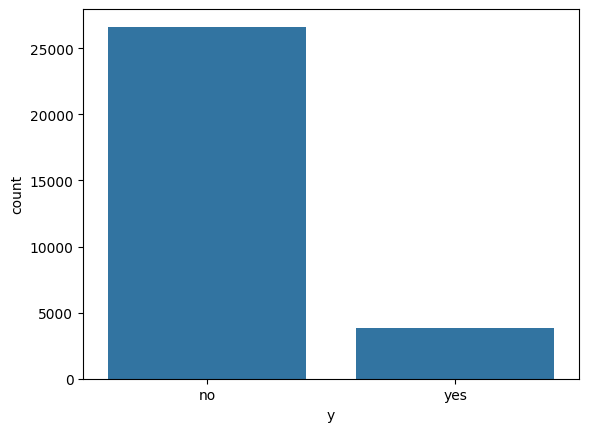

In [20]:
# Visualize dataset and check dataset balance
sns.countplot(x='y', data=data)
print(data.y.value_counts())

### Transform Data (Encoding)

In [21]:
# Hot-encoding of categorical data to get numerical values and to not make the model think the number holds importance
hot_encoded_columns = ['job', 'marital', 'education', 'month', 'poutcome','day_of_week']
data = pd.get_dummies(data, columns=hot_encoded_columns, drop_first=True, dtype=int)

# Since the following are simply binary categories, transforming them to 0 and 1
label_encoded_columns = ['default', 'housing', 'loan', 'contact']

for col in label_encoded_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# 999 indicates client was not previously contacted, change to -1 for less variance
data.pdays = data.pdays.replace(999, -1)

# Setting output "no" to 0 and "yes" to 1
data.y = np.where(data.y == 'no', 0, 1)

data.head(10)

,age,default,housing,loan,contact,duration,campaign,pdays,previous,emp.var.rate,...,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,0,0,0,1,261,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
2,37,0,1,0,1,226,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
3,40,0,0,0,1,151,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
4,56,0,0,1,1,307,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
6,59,0,0,0,1,139,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
8,24,0,1,0,1,380,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
9,25,0,1,0,1,50,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
11,25,0,1,0,1,222,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
12,29,0,0,1,1,137,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0
13,57,0,1,0,1,293,1,-1,0,1.1,...,1,0,0,0,1,0,1,0,0,0


### Standardize Data and Save to new File

In [22]:
# Standardize the features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data.drop(columns=['y']))

# Put the stndardised data in new file
normalized_df = pd.DataFrame(normalized_data, columns=data.drop(columns=['y']).columns)
full_normalized_dataset = pd.concat([normalized_df, data['y'].reset_index(drop=True)], axis=1)
full_normalized_dataset.to_csv('bank-additional-full-normalized.csv', index=False)

data=full_normalized_dataset
data

,age,default,housing,loan,contact,duration,campaign,pdays,previous,emp.var.rate,...,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,y
0,1.642253,-0.00992,-1.087593,-0.430559,1.426584,0.005792,-0.559335,-0.184999,-0.371616,0.727477,...,-0.359889,-0.146664,-0.128467,0.424333,-0.201625,1.963556,-0.515199,-0.492681,-0.501404,0
1,-0.196452,-0.00992,0.919461,-0.430559,1.426584,-0.127944,-0.559335,-0.184999,-0.371616,0.727477,...,-0.359889,-0.146664,-0.128467,0.424333,-0.201625,1.963556,-0.515199,-0.492681,-0.501404,0
2,0.093870,-0.00992,-1.087593,-0.430559,1.426584,-0.414520,-0.559335,-0.184999,-0.371616,0.727477,...,-0.359889,-0.146664,-0.128467,0.424333,-0.201625,1.963556,-0.515199,-0.492681,-0.501404,0
3,1.642253,-0.00992,-1.087593,2.322562,1.426584,0.181559,-0.559335,-0.184999,-0.371616,0.727477,...,-0.359889,-0.146664,-0.128467,0.424333,-0.201625,1.963556,-0.515199,-0.492681,-0.501404,0
4,1.932575,-0.00992,-1.087593,-0.430559,1.426584,-0.460373,-0.559335,-0.184999,-0.371616,0.727477,...,-0.359889,-0.146664,-0.128467,0.424333,-0.201625,1.963556,-0.515199,-0.492681,-0.501404,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,3.287410,-0.00992,0.919461,-0.430559,-0.700975,0.284727,-0.559335,-0.184999,-0.371616,-0.638666,...,2.778637,-0.146664,-0.128467,0.424333,-0.201625,-0.509280,-0.515199,-0.492681,-0.501404,1
30484,0.674513,-0.00992,-1.087593,-0.430559,-0.700975,0.471957,-0.559335,-0.184999,-0.371616,-0.638666,...,2.778637,-0.146664,-0.128467,0.424333,-0.201625,-0.509280,-0.515199,-0.492681,-0.501404,0
30485,1.642253,-0.00992,0.919461,-0.430559,-0.700975,-0.269321,-0.191702,-0.184999,-0.371616,-0.638666,...,2.778637,-0.146664,-0.128467,0.424333,-0.201625,-0.509280,-0.515199,-0.492681,-0.501404,0
30486,0.480965,-0.00992,-1.087593,-0.430559,-0.700975,0.697398,-0.559335,-0.184999,-0.371616,-0.638666,...,2.778637,-0.146664,-0.128467,0.424333,-0.201625,-0.509280,-0.515199,-0.492681,-0.501404,1


### Balance Dataset

y
1    26629
0    26629
Name: count, dtype: int64


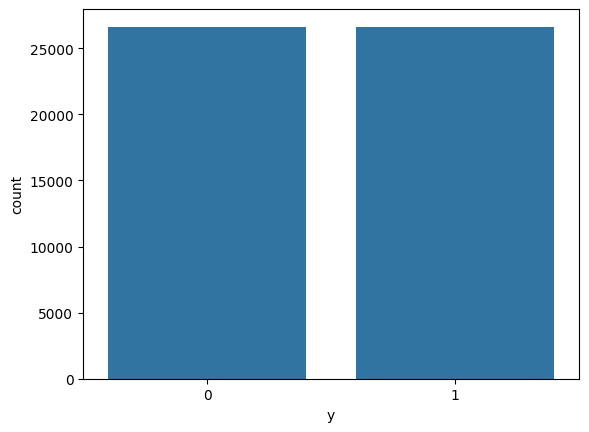

In [23]:
# Separate majority and minority classes
majority = data[data.y == 0]
minority = data[data.y == 1]

# Oversample minority class
minority_oversampled = resample(
    minority,
    replace=True,              # With replacement
    n_samples=len(majority)   # Match majority class size
)

# Combine oversampled minority with majority
data = pd.concat([minority_oversampled, majority])
data = shuffle(data, random_state=random_state)

# Check dataset balance
sns.countplot(x='y', data=data)
print(data.y.value_counts())

### Split Data

(53258, 47)
47


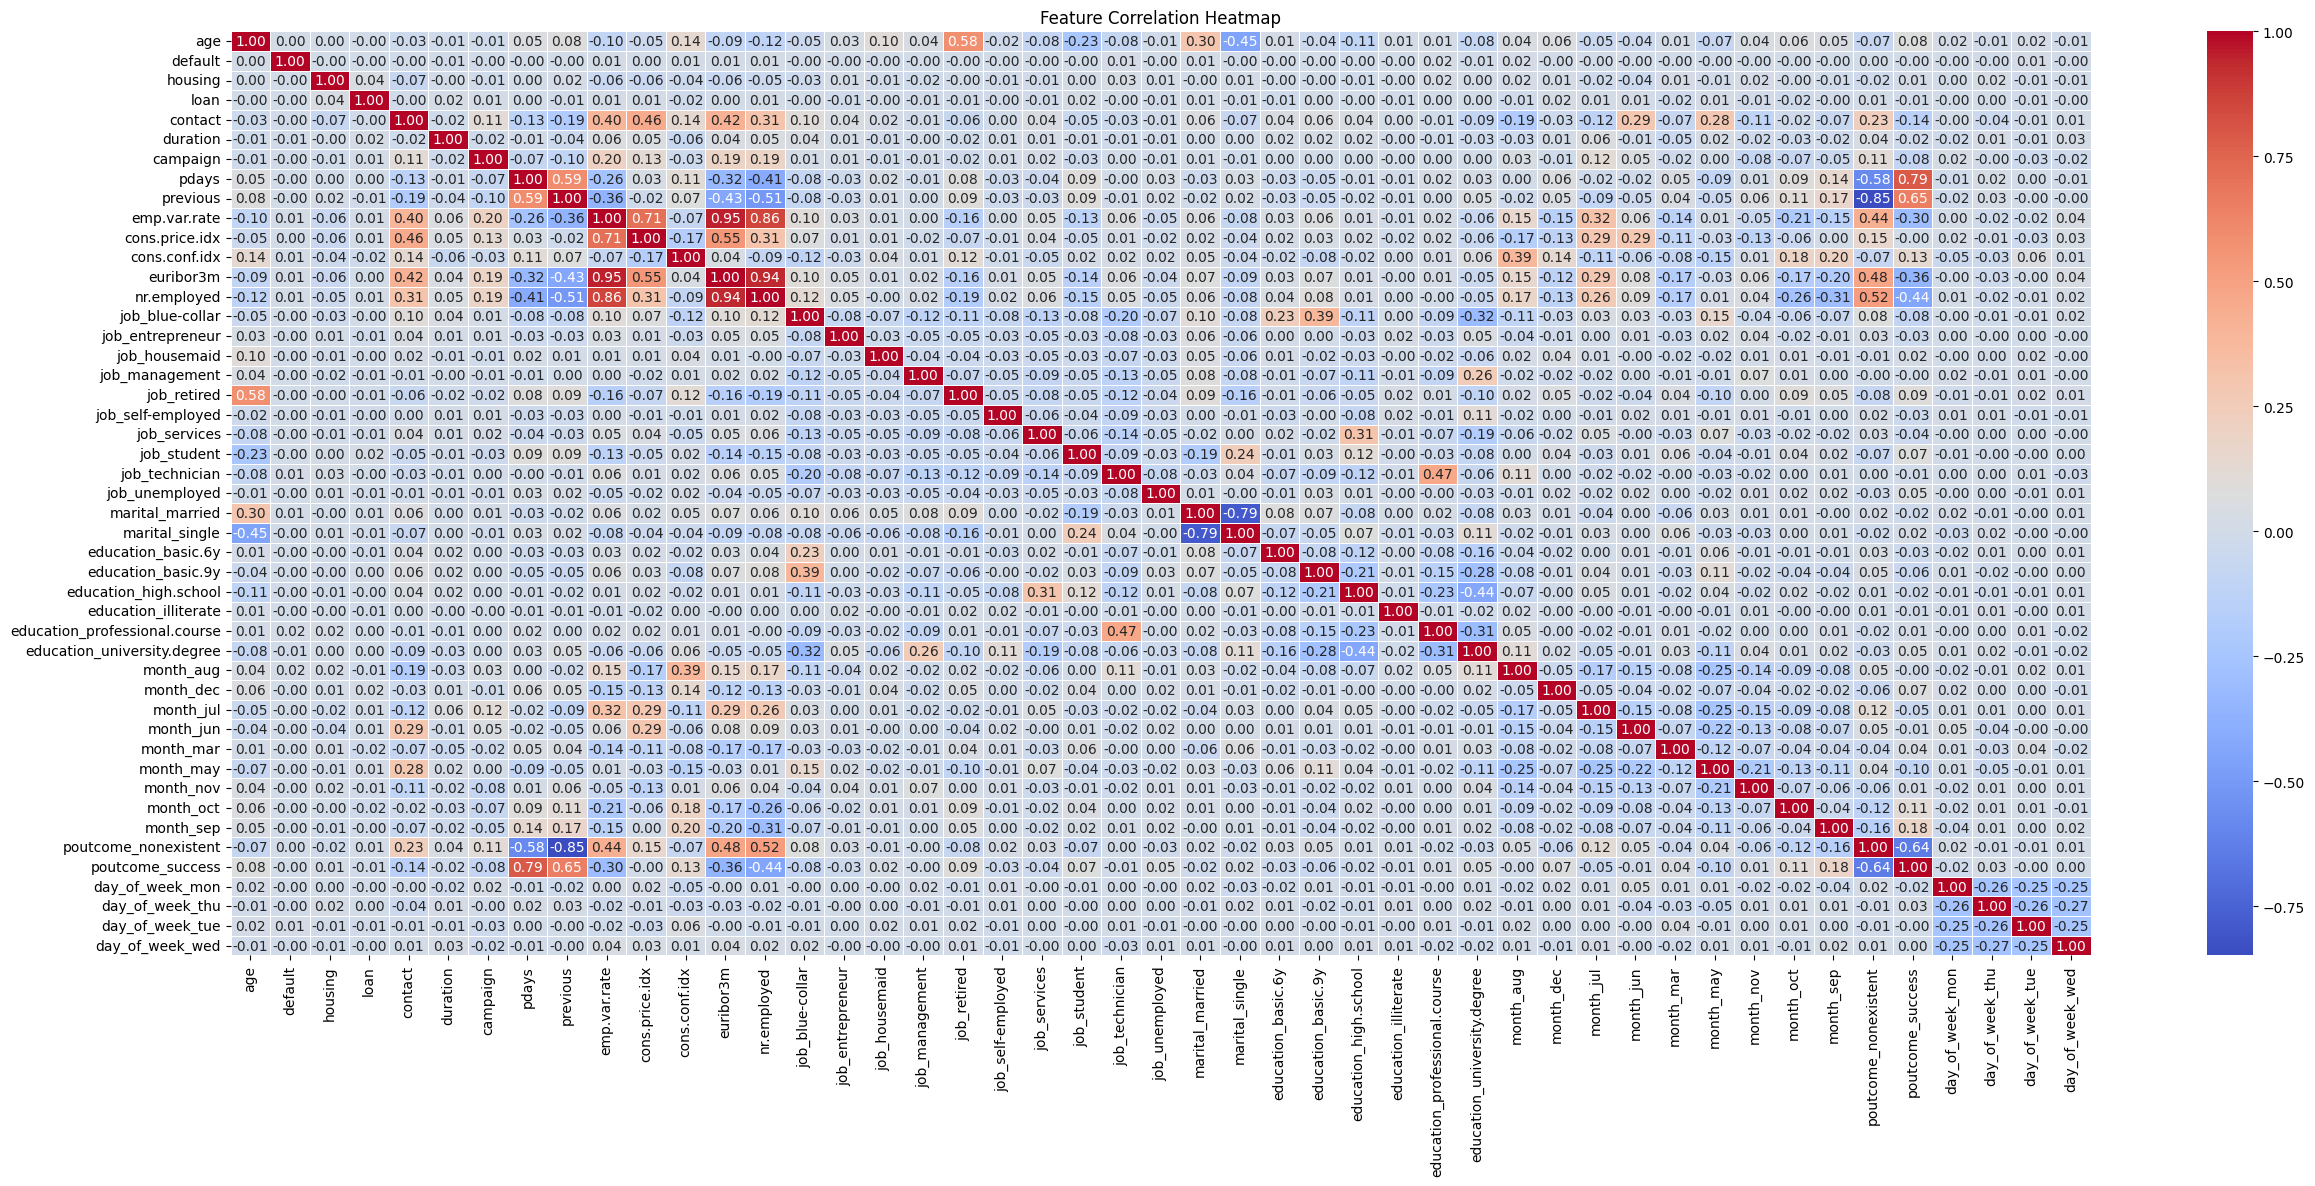

In [24]:
# Split the features to X and the target to y
X = data.drop(columns=['y']) # features
y = data['y'] # target

print(X.shape)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape[1])

feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]
plot_heatmap(X_train, feature_names=feature_names, title="Feature Correlation Heatmap")

## Build Model (Neural Network)

In [25]:
# Declaring model parameters
learning_rate=0.0005
activation_func='relu'
output_func='sigmoid'
loss='binary_crossentropy'

# Building model structure
model = Sequential()

model.add(Dense(128, activation=activation_func, input_shape=(X_train.shape[1],),name= 'hidden_layer_1'))
model.add(Dense(64, activation=activation_func, name= 'hidden_layer_2'))
model.add(Dense(32,  activation=activation_func, name= 'hidden_layer_3'))
model.add(Dense(16,  activation=activation_func, name= 'hidden_layer_4'))
model.add(Dense(8,  activation=activation_func, name= 'hidden_layer_5'))
model.add(Dense(1,  activation=output_func, name= 'output'))

# Compiling the model
optimizer = Adam(learning_rate= learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'precision', 'recall'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)               │ (None, 128)                 │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_2 (Dense)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_3 (Dense)               │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_4 (Dense)               │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer_5 (Dense)               │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model


In [ ]:
# Declaring training param and train the model
epochs=300
batch_size=150
training_results = model.fit(X_train, y_train, verbose=1, batch_size=batch_size, validation_split=0.1, epochs=epochs)

Epoch 1/300
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7340 - loss: 0.5195 - precision: 0.7056 - recall: 0.8122 - val_accuracy: 0.8766 - val_loss: 0.2971 - val_precision: 0.8633 - val_recall: 0.8985
Epoch 2/300
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8758 - loss: 0.2996 - precision: 0.8433 - recall: 0.9233 - val_accuracy: 0.8871 - val_loss: 0.2771 - val_precision: 0.8650 - val_recall: 0.9208
Epoch 3/300
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8875 - loss: 0.2775 - precision: 0.8501 - recall: 0.9411 - val_accuracy: 0.8965 - val_loss: 0.2645 - val_precision: 0.8721 - val_recall: 0.9323
Epoch 4/300
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8962 - loss: 0.2615 - precision: 0.8585 - recall: 0.9489 - val_accuracy: 0.9012 - val_loss: 0.2551 - val_precision: 0.8732 - val_recall: 0.9416
Epoch 5/300
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9025 - loss: 0.2474 - precision: 0.8651 - recall: 0.9538 - val_accuracy: 0.9092 - val_los

## Evaluation and Predictions

In [ ]:
# Evaluate model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
test_f1_score = 2 * ((test_precision * test_recall) / (test_precision + test_recall + K.epsilon()))

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.2f}")
print(f"Test precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1: { test_f1_score: .2f}")
print()

# Make predictions
y_pred = (model.predict(X_test, verbose=0) >= 0.5).astype("int32")

## Visualization

In [ ]:
# Train History Visualization
history_graph(training_results,'accuracy','val_accuracy','Train Accuracy', 'Validation Accuracy', 'Model Accuracy', 'Accuracy')
history_graph(training_results,'loss','val_loss','Train Loss', 'Validation Loss', 'Model Loss', 'Loss')

In [ ]:
# Train History Visualization
history_graph(training_results,'recall','val_recall','Train Recall', 'Validation Recall', 'Model Recall', 'Recall')
history_graph(training_results,'precision','val_precision','Train Precision', 'Validation Precision', 'Model Precision', 'Precision')

In [ ]:
# Confusion Matrix Visualization
heatmap('No','Yes', confusion_matrix(y_test, y_pred))